The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
# !pip install l git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install d2l==0.16.1

In [ ]:
# !pip install tensorflow
!pip install tensorflow==1.13.1


In [1]:
# tính đạo hàm cho hàm tổng quát
%matplotlib inline
import d2l
# from mxnet import np, npx
import math
# npx.set_np()
import numpy as np
from scipy import optimize

def f(x):
    x=x[-1]
    return x*x +  10*math.sin(x)  # Objective function

def gradf(x):
    x=x[-1]
    return np.asarray(2*x +  10*math.cos(x))  # Its derivative

def function(theta):
    x=theta[-1]
    return math.log(1+(abs(x))**(2+math.sin(x)))
    # return x**3

def general_grad(theta,function):
    theta = np.asarray(theta)
    # print(theta.shape)
    eps = np.ones(theta.shape[0])*(1e-6)
    return optimize.approx_fprime(theta, function, eps)  

ModuleNotFoundError: No module named 'd2l'

In [2]:
# implement adam and other 
import numpy as np
import math
class Optimizer:
  def __init__(self,list_param,learnning_rate,max_epoch,gradf,function):
    print(list_param)
    self.param = np.asarray(list_param)
    self.learnning_rate = learnning_rate
    self.epoch = max_epoch
    self.gradf = gradf
    self.function = function

  def gd(self,dimention):
    param=self.param
    theta = [param]

    for i in range(self.epoch):
        param =np.add(param, - self.learnning_rate * self.gradf(param,self.function))
        theta.append(param)
        if np.linalg.norm(theta[-1]-theta[-2])<=1e-8:
            break
    
    print('epoch ',i, 'x:', param)
    return theta,i


  def GD_momentum(self):
    # Suppose we want to store history of theta
    theta = [self.param]
    gamma=0.9
    v_old = np.zeros_like(self.param)

    for it in range(self.epoch):
        v_new = gamma*v_old + self.learnning_rate*self.gradf(theta[-1],self.function)
        theta_new = np.add(theta[-1], -1* v_new)
        # if has_converged(theta_new, grad):
            # break 
        theta.append(theta_new)
        v_old = v_new
        # if it%10==0:
            # print(v_new)
        if np.linalg.norm(theta[-1]-theta[-2])<=1e-8:
            break

    print('epoch',it,'x',theta_new)
    return theta ,it



  def GD_nag(self):
    # Suppose we want to store history of theta
    gamma=0.9
    theta = [self.param]
    v_old = np.zeros_like(self.param)

    for it in range(self.epoch):
        v_new = gamma*v_old + self.learnning_rate*(self.gradf(theta[-1],self.function)-gamma*v_old)
        theta_new = theta[-1] - v_new
        # if has_converged(theta_new, grad):
            # break 
        theta.append(theta_new)
        v_old = v_new
        if np.linalg.norm(theta[-1]-theta[-2])<=1e-8:
            break

    print('epoch',it,'x',theta_new)
    return theta ,it



  def AdaGrad(self):
      eps=1e-6
      theta=[self.param]
      s=[]

      for i in range(theta[-1].shape[0]):
          s.append(0)

      s=np.asarray(s)
      for it in range(self.epoch):
          s=s + np.multiply(self.gradf(theta[-1] , self.function),self.gradf(theta[-1],self.function))
          theta_new = theta[-1]- np.multiply(self.learnning_rate / np.sqrt(s+np.ones(s.shape[0])*eps),self.gradf(theta[-1],self.function))
          theta.append(theta_new)
          if np.linalg.norm(theta[-1]-theta[-2])<=1e-8:
              break

      print('epoch',it,'x',theta_new)
      return theta,it


  def RMSPROP(self):
    eps=1e-6
    gamma=0.9
    theta=[self.param]
    s=[]
  
    for i in range(theta[-1].shape[0]):
        s.append(0)
    s=np.asarray(s)
    for it in range(self.epoch):
        s = gamma * s + (1 - gamma) * np.multiply(self.gradf(theta[-1],self.function),self.gradf(theta[-1],self.function))
        theta_new =theta[-1] - np.multiply(self.learnning_rate / np.sqrt(s+np.ones(s.shape[0])*eps),self.gradf(theta[-1],self.function))
        theta.append(theta_new)
        if np.linalg.norm(theta[-1]-theta[-2])<=1e-8:
            break
    print('epoch',it,'x',theta_new)
    return theta,it



  def Adam(self, alpha = 0.001, beta_1 = 0.9, beta_2 = 0.999):
    alpha = alpha
    beta_1 = beta_1
    beta_2 = beta_2					#initialize the values of the parameters
    eps = 1e-8
    theta = [self.param]
    m_t = np.zeros(theta[-1].shape[0])
    v_t = np.zeros(theta[-1].shape[0])
    # theta_new = np.zeros(theta[-1].shape[0])
    for it in range(self.epoch):
        g_t = self.gradf(theta[-1],self.function)		
        m_t = beta_1*m_t + (1-beta_1)*g_t	
        v_t = beta_2*v_t + (1-beta_2)*(np.power(g_t, 2))	
        m_cap = np.true_divide(m_t,(1-(beta_1**(it + 1))))
        v_cap = np.true_divide(v_t,(1-(beta_2**(it + 1))))									
        theta_new = theta[-1] - np.true_divide(alpha*m_cap,(np.sqrt(v_cap)+np.ones(theta[-1].shape[0])*eps))	#updates the parameters
        theta.append(theta_new)
        if np.linalg.norm(theta[-1]-theta[-2])<=1e-8:
            break
        # if it < 20:
            # print(np.true_divide(alpha*m_cap,(np.sqrt(v_cap)+np.ones(theta[-1].shape[0])*eps)))
            # print(v_t)
      # if it<20:
        # print(m_t,v_t,m_cap,v_cap,theta_new)
    
    print('Adam: epoch',it,'x',theta_new)
    return theta,it






$$f(\mathbf{x}) = log(1+(\mid x\mid)^{2+sinx})$$


In [3]:
def function1(theta):
    x = theta[-1]
    x = float(x)
    return math.log(1+(abs(x))**(2+math.sin(x)))

In [4]:
op=Optimizer(list_param=[8],learnning_rate=1,max_epoch=10000,gradf=general_grad,function=function1)
gd = op.gd(1)
print('Gradient descent',(gd[0][-1]))
momentum = op.GD_momentum()
print('Momentum',(momentum[0][-1]))
Nag = op.GD_nag()
print('Nag',(Nag[0][-1]))
adagrad = op.AdaGrad()
print('Adagrad',(adagrad[0][-1]))
rmsprop = op.RMSPROP()
print('RMSprop',(rmsprop[0][-1]))
adam = op.Adam(alpha=1.5)
print('Adam',(adam[0][-1]))

NameError: name 'general_grad' is not defined

In [ ]:
%matplotlib inline
from IPython import display
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

In [ ]:
def use_svg_display():  
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

In [ ]:
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

In [ ]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [ ]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [ ]:
# visualize
def show_trace(res,function):
    res1=[]
    for item in res:
        res1.append(item[0])
    n = max(abs(min(res1)), abs(max(res1)))
    f_line = np.arange(-9, 8, 0.01)
    # d2l.set_figsize((3.5, 2.5))
    # d2l.plot([f_line, res1], [[function([x]) for x in f_line], [function(x) for x in res]],
    #          'x', 'f(x)', fmts=['-', '-o'])
    plot([f_line, res1], [[function([x]) for x in f_line], [function(x) for x in res]],
             'x', 'f(x)', fmts=['-', '-o'])



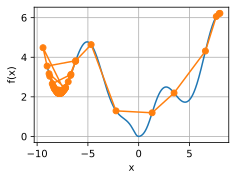

In [ ]:
show_trace(momentum[0],function1)

$$f(\mathbf{x})=(2+\frac{sin 50x}{50})(arctan x)^2$$

In [ ]:
def function2(theta):
    x = theta[-1]
    return (2 + math.sin(50*x)/50) * (math.atan(x))**2

In [ ]:
op=Optimizer(list_param=[4.03],learnning_rate=2,max_epoch=10000,gradf=general_grad,function=function2)
gd = op.gd(1)
print('Gradient descent',(gd[0][-1]))
momentum = op.GD_momentum()
print('Momentum',(momentum[0][-1]))
Nag = op.GD_nag()
print('Nag',(Nag[0][-1]))
adagrad = op.AdaGrad()
print('Adagrad',(adagrad[0][-1]))
rmsprop = op.RMSPROP()
print('RMSprop',(rmsprop[0][-1]))
adam = op.Adam(alpha=2)
print('Adam',(adam[0][-1]))

[4.03]
epoch  9999 x: [-456.60608974]
Gradient descent [-456.60608974]
epoch 9999 x [930.83453448]
Momentum [930.83453448]
epoch 9999 x [-119.53706345]
Nag [-119.53706345]
epoch 148 x [-5.04527632e-07]
Adagrad [-5.04527632e-07]
epoch 9999 x [329.12282844]
RMSprop [329.12282844]
Adam: epoch 346 x [-5.26884698e-07]
Adam [-5.26884698e-07]


In [ ]:
op=Optimizer(list_param=[4.03],learnning_rate=0.01,max_epoch=10000,gradf=general_grad,function=function2)
gd = op.gd(1)
print('Gradient descent',(gd[0][-1]))
momentum = op.GD_momentum()
print('Momentum',(momentum[0][-1]))
Nag = op.GD_nag()
print('Nag',(Nag[0][-1]))
adagrad = op.AdaGrad()
print('Adagrad',(adagrad[0][-1]))
rmsprop = op.RMSPROP()
print('RMSprop',(rmsprop[0][-1]))
adam = op.Adam(alpha=0.01)
print('Adam',(adam[0][-1]))

[4.03]
epoch  9 x: [3.98626396]
Gradient descent [3.98626396]
epoch 244 x [3.98626405]
Momentum [3.98626405]
epoch 205 x [3.98626423]
Nag [3.98626423]
epoch 63 x [3.98626399]
Adagrad [3.98626399]
epoch 9999 x [3.98114481]
RMSprop [3.98114481]
Adam: epoch 247 x [3.98626404]
Adam [3.98626404]


In [ ]:
adam = op.Adam(alpha=0.06)
print('Adam',(adam[0][-1]))

Adam: epoch 237 x [3.98626386]
Adam [3.98626386]


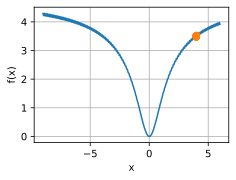

In [ ]:
def show_trace(res,function):
    res1=[]
    for item in res:
        res1.append(item[0])
    n = max(abs(min(res1)), abs(max(res1)))
    f_line = np.arange(-9, 6, 0.01)
    # d2l.set_figsize((3.5, 2.5))
    # d2l.plot([f_line, res1], [[function([x]) for x in f_line], [function(x) for x in res]],
    #          'x', 'f(x)', fmts=['-', '-o'])
    plot([f_line, res1], [[function([x]) for x in f_line], [function(x) for x in res]],
             'x', 'f(x)', fmts=['-', '-o'])
show_trace(Nag[0],function2)

$$f(\mathbf{x,y})=(1-x)^2+100(y-x^2)^2$$

In [ ]:
def function3(theta):
    x=theta[0]
    y=theta[1]
    return (1-x)**2 + 100*(y-x**2)**2

In [ ]:
param = [-4,4]
op=Optimizer(list_param=param,learnning_rate=0.1,max_epoch=10000,gradf=general_grad,function=function3)
gd = op.gd(1)
print('Gradient descent',(gd[0][-1]), 'f = ',function3(gd[0][-1]))
momentum = op.GD_momentum()
print('Momentum',(momentum[0][-1]), 'f = ',function3(momentum[0][-1]))
Nag = op.GD_nag()
print('Nag',(Nag[0][-1]), 'f = ',function3(Nag[0][-1]))
adagrad = op.AdaGrad()
print('Adagrad',(adagrad[0][-1]), 'f = ',function3(adagrad[0][-1]))
rmsprop = op.RMSPROP()
print('RMSprop',(rmsprop[0][-1]), 'f = ',function3(rmsprop[0][-1]))
adam = op.Adam()
print('Adam',(adam[0][-1]), 'f = ',function3(adam[0][-1]))

[-4, 4]
epoch  2 x: [-2.81771398e+11  7.35002440e+07]
Gradient descent [-2.81771398e+11  7.35002440e+07] f =  6.30358520329745e+47
epoch 331 x [-2.81771398e+12  7.35002404e+08]
Momentum [-2.81771398e+12  7.35002404e+08] f =  6.303585202975263e+51
epoch 170 x [-1.48300736e+12  3.86843372e+08]
Nag [-1.48300736e+12  3.86843372e+08] f =  4.836968104148629e+50
epoch 9999 x [-2.38970219  5.71615898]
Adagrad [-2.38970219  5.71615898] f =  11.493086629168781
epoch 9999 x [0.29998076 0.01498988]
RMSprop [0.29998076 0.01498988] f =  1.0525055719015053
Adam: epoch 9999 x [-2.38683934  5.70248723]
Adam [-2.38683934  5.70248723] f =  11.473689445725089


**Thí nghiệm classifier MNIST**

In [ ]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
# import tensorflow_datasets
# mnist = tensorflow_datasets.load('mnist')
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Instructions for updating:
Please use tf.data to implement this functionality.


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz


Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
non-resource variables are not supported in the long term


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
# Parameters
learning_rate = 0.01
epoch = 500
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

In [ ]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [ ]:
# Construct model
logits = neural_net(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
# Start training
def training(op):
    if op == 'Adam':
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    elif op == 'RMSprop':
        optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
    elif op == 'Momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9, use_nesterov=True)

    train_op = optimizer.minimize(loss_op)

    # Evaluate model (with test logits, for dropout to be disabled)
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    loss_list = np.zeros(epoch)
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for step in range(epoch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                Y: batch_y})
            loss_list[step] = loss
            if step % display_step == 0 or step == 1:    
                print("Step " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

        print("Optimization Finished!")

        # Calculate accuracy for MNIST test images
        print("Testing Accuracy:", \
            sess.run(accuracy, feed_dict={X: mnist.test.images,
                                          Y: mnist.test.labels}))
    return loss_list

adam_loss = training('Adam')   
rms_loss = training('RMSprop')  
momentum_loss = training('Momentum')

Step 0, Minibatch Loss= 1162.8867, Training Accuracy= 0.188
Step 1, Minibatch Loss= 925.5210, Training Accuracy= 0.266
Step 100, Minibatch Loss= 48.3610, Training Accuracy= 0.875
Step 200, Minibatch Loss= 14.9469, Training Accuracy= 0.953
Step 300, Minibatch Loss= 34.6041, Training Accuracy= 0.898
Step 400, Minibatch Loss= 27.0962, Training Accuracy= 0.906
Optimization Finished!
Testing Accuracy: 0.9295
Step 0, Minibatch Loss= 1032.3191, Training Accuracy= 0.234
Step 1, Minibatch Loss= 685.4941, Training Accuracy= 0.297
Step 100, Minibatch Loss= 23.4072, Training Accuracy= 0.922
Step 200, Minibatch Loss= 7.3856, Training Accuracy= 0.969
Step 300, Minibatch Loss= 0.8384, Training Accuracy= 0.984
Step 400, Minibatch Loss= 3.2400, Training Accuracy= 0.969
Optimization Finished!
Testing Accuracy: 0.9208
Step 0, Minibatch Loss= 2668.1707, Training Accuracy= 0.242
Step 1, Minibatch Loss= 4229.7642, Training Accuracy= 0.273
Step 100, Minibatch Loss= 1.8307, Training Accuracy= 0.406
Step 200, 

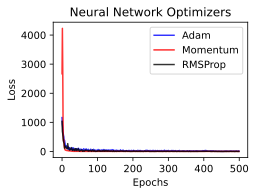

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(adam_loss, color='blue', alpha=0.8, label='Adam')
plt.plot(momentum_loss, color='red', alpha=0.8, label='Momentum')
plt.plot(rms_loss, color='black', alpha=0.8, label='RMSProp')
plt.title("Neural Network Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##**END**##